In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # unsqueeze add extra dimension to accomodate for B*Nin batches * number of inputs
t_u = torch.tensor(t_u).unsqueeze(1)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples) # random

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print(train_indices, val_indices)

# split data in train and validation sets
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

tensor([ 2,  6,  1,  7,  0,  5,  8, 10,  4]) tensor([3, 9])


In [2]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train:.4f}, Validation loss {loss_val:.4f}')

In [42]:
from collections import OrderedDict

# seq_model = nn.Sequential(OrderedDict(
#     [('hidden_linear', nn.Linear(1, 13)),
#      ('hidden_activation', nn.Tanh()),
#      ('hidden2_linear', nn.Linear(13, 25)),
#      ('hidden2_activation', nn.Tanh()),
#      ('output_linear', nn.Linear(25, 1))
# ])) # more hidden layers => overfitting

seq_model = nn.Sequential(OrderedDict(
    [('hidden_linear', nn.Linear(1, 100)),
     ('hidden_activation', nn.Tanh()),
     ('output_linear', nn.Linear(100, 1))
])) # => more linear

print(seq_model)
print(seq_model.output_linear.bias)
[(name, param.shape) for name, param in seq_model.named_parameters()]

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=100, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=100, out_features=1, bias=True)
)
Parameter containing:
tensor([-0.0869], requires_grad=True)


[('hidden_linear.weight', torch.Size([100, 1])),
 ('hidden_linear.bias', torch.Size([100])),
 ('output_linear.weight', torch.Size([1, 100])),
 ('output_linear.bias', torch.Size([1]))]

In [43]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs=5000,
              optimizer=optimizer,
              model=seq_model,
              loss_fn=nn.MSELoss(),
              t_u_train=train_t_un,
              t_u_val=val_t_un,
              t_c_train=train_t_c,
              t_c_val=val_t_c)

print(f'output: {seq_model(val_t_un)}')
print(f'answer: {val_t_c}')
print(f'hidden: {seq_model.hidden_linear.weight.grad}')

Epoch 1, Training loss 134.6348, Validation loss 505.2463
Epoch 2, Training loss 109.3996, Validation loss 441.5821
Epoch 3, Training loss 91.5266, Validation loss 391.7192
Epoch 1000, Training loss 3.4600, Validation loss 15.7997
Epoch 2000, Training loss 2.7834, Validation loss 7.8176
Epoch 3000, Training loss 2.4794, Validation loss 5.1785
Epoch 4000, Training loss 2.2811, Validation loss 3.8997
Epoch 5000, Training loss 2.1362, Validation loss 3.2335
output: tensor([[26.8620],
        [15.2740]], grad_fn=<AddmmBackward0>)
answer: tensor([[28.],
        [13.]])
hidden: tensor([[ 0.0025],
        [-0.0208],
        [-0.0216],
        [ 0.0095],
        [-0.0101],
        [-0.0092],
        [ 0.0042],
        [ 0.0050],
        [-0.0072],
        [-0.0054],
        [-0.0032],
        [ 0.0012],
        [ 0.0017],
        [ 0.0083],
        [ 0.0065],
        [ 0.0021],
        [ 0.0071],
        [-0.0052],
        [-0.0025],
        [ 0.0064],
        [ 0.0003],
        [ 0.0129],
   

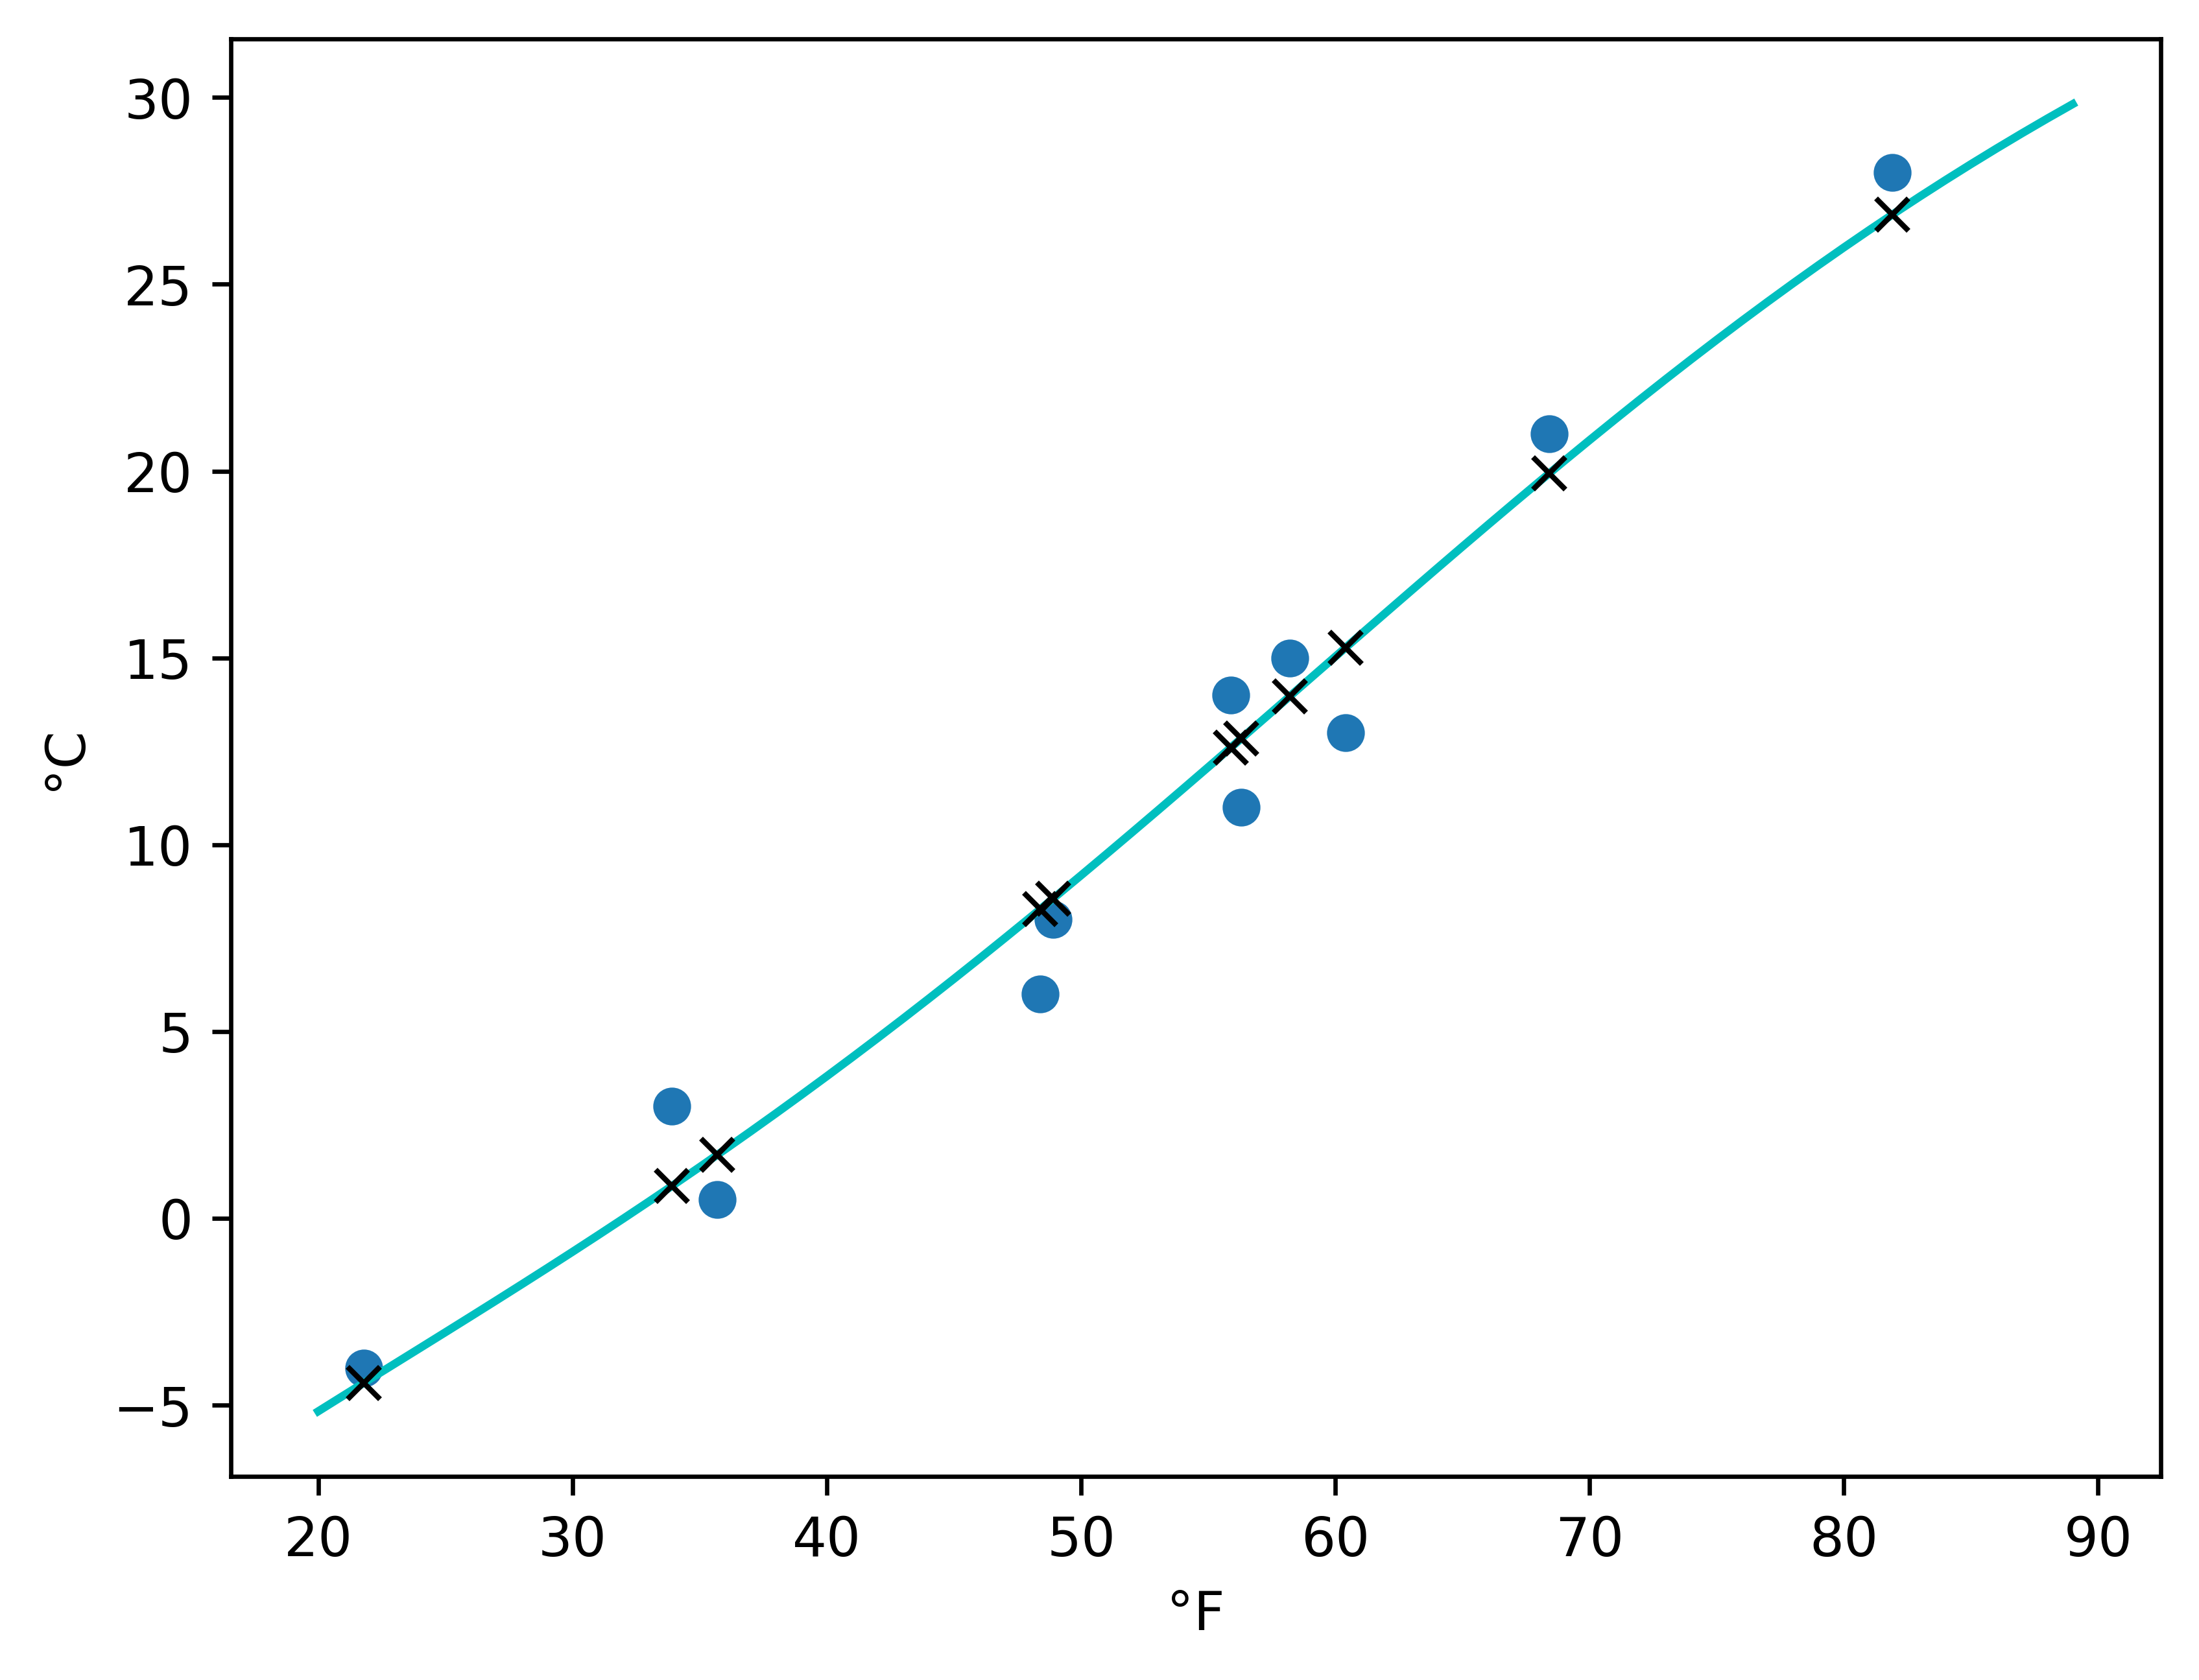

In [44]:
# plot something...
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel('°F')
plt.ylabel('°C')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')